feature: 7dayav;3dayav;
target: signal

In [306]:
import pandas as pd
import numpy as np

In [307]:
def from_UTC_to_data(eth_data):
    desired_column = pd.to_datetime(eth_data['snapped_at'])
    eth_data.drop('snapped_at', axis = 1, inplace = True)
    eth_data.insert(0, 'date', desired_column)
    
    return eth_data

In [308]:
def seven_day_average(data):
    count = len(data.iloc[:,1])
    data['price_7d'] = data['volume_7d'] = 0
    for i in range(count):
        if i <= 6:
            data.iloc[i,3] = data.iloc[0:i+1,1].sum()/(i+1.0)
            data.iloc[i,4] = data.iloc[0:i+1,2].sum()/(i+1.0)
        else:
            data.iloc[i,3] = data.iloc[i-6:i+1,1].sum()/7.0
            data.iloc[i,4] = data.iloc[i-6:i+1,2].sum()/7.0
    return data


In [309]:
def price_change_and_target(data):
    count = len(data.iloc[:,1])
    data['price_change'] = data['target'] = 0
    for i in range(count):
        if i == 0:
            data.iloc[i,5] = 0
            data.iloc[i,6] = 0
        else:
            data.iloc[i,5] = data.iloc[i,1] - data.iloc[i-1,1]
            data.iloc[i,6] = np.where(data.iloc[i,5] >= 0, 1, -1)
    return data

In [310]:
def cumsumf(data):
    data['cumsum'] = np.exp(1)**(data['return'].cumsum())
    return data

In [311]:
data = pd.read_excel("D:\BaiduNetdiskDownload\Blockdata\eth-usd-max1.xlsx",sheet_name= 'eth-usd-max')
selected_data = data.iloc[10:]
eth_data = pd.DataFrame()
eth_data = selected_data.loc[:,['snapped_at','price','total_volume']]
eth_data = from_UTC_to_data(eth_data)
eth_data = seven_day_average(eth_data)
eth_data = price_change_and_target(eth_data)
eth_data = eth_data.dropna()

eth_data.head(10)

print(eth_data['date'])


10     2015-08-18 00:00:00+00:00
11     2015-08-19 00:00:00+00:00
12     2015-08-20 00:00:00+00:00
13     2015-08-21 00:00:00+00:00
14     2015-08-22 00:00:00+00:00
                  ...           
2980   2023-10-05 00:00:00+00:00
2981   2023-10-06 00:00:00+00:00
2982   2023-10-07 00:00:00+00:00
2983   2023-10-08 00:00:00+00:00
2984   2023-10-09 00:00:00+00:00
Name: date, Length: 2974, dtype: datetime64[ns, UTC]


In [312]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [313]:
X = eth_data[['price','total_volume','price_7d','volume_7d','price_change']]
Y = eth_data['target']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
knn_clf = KNeighborsClassifier(n_neighbors = 90)
knn_clf.fit(X_train,Y_train)
print('训练集准确率：%.2f'%knn_clf.score(X_train, Y_train))
print('验证集准确率：%.2f'%knn_clf.score(X_test, Y_test))

训练集准确率：0.55
验证集准确率：0.52


In [314]:
eth_data['pr_target'] = knn_clf.predict(X)
eth_data['return'] = np.log(eth_data['price']/eth_data['price'].shift(1))
eth_data = cumsumf(eth_data)
eth_data.head(10)

,date,price,total_volume,price_7d,volume_7d,price_change,target,pr_target,return,cumsum
10,2015-08-18 00:00:00+00:00,1.281393,1.696013e+06,1.281393,1.696013e+06,0.000000,0,-1,NaN,NaN
11,2015-08-19 00:00:00+00:00,1.252739,1.537201e+06,1.267066,1.616607e+06,-0.028654,-1,-1,-0.022616,0.977638
12,2015-08-20 00:00:00+00:00,1.484195,2.967731e+06,1.339442,2.066982e+06,0.231456,1,-1,0.169541,1.158267
13,2015-08-21 00:00:00+00:00,1.406315,1.742882e+06,1.356160,1.985957e+06,-0.077880,-1,-1,-0.053900,1.097489
14,2015-08-22 00:00:00+00:00,1.380722,9.145887e+05,1.361073,1.771683e+06,-0.025593,-1,-1,-0.018366,1.077516
15,2015-08-23 00:00:00+00:00,1.355182,1.610696e+06,1.360091,1.744852e+06,-0.025539,-1,-1,-0.018670,1.057585
16,2015-08-24 00:00:00+00:00,1.246572,6.964766e+05,1.343874,1.595084e+06,-0.108610,-1,-1,-0.083539,0.972825
17,2015-08-25 00:00:00+00:00,1.160828,1.053169e+06,1.326650,1.503249e+06,-0.085743,-1,-1,-0.071263,0.905911
18,2015-08-26 00:00:00+00:00,1.119639,1.151700e+06,1.307636,1.448178e+06,-0.041189,-1,-1,-0.036127,0.873767
19,2015-08-27 00:00:00+00:00,1.133691,6.814602e+05,1.257564,1.121568e+06,0.014052,1,-1,0.012472,0.884733


In [315]:
new_eth_data = eth_data[eth_data['pr_target'] == 1]
new_eth_data = cumsumf(new_eth_data)
new_eth_data.head()

C:\Users\72722\AppData\Local\Temp\ipykernel_7356\3810844776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cumsum'] = np.exp(1)**(data['return'].cumsum())


,date,price,total_volume,price_7d,volume_7d,price_change,target,pr_target,return,cumsum
163,2016-01-18 00:00:00+00:00,1.398301,4073710.12,1.228702,2.339128e+06,0.076445,1,1,0.056221,1.057832
170,2016-01-25 00:00:00+00:00,2.481396,10884776.21,1.751954,4.359313e+06,0.349705,1,1,0.151906,1.231370
171,2016-01-26 00:00:00+00:00,2.086783,11669540.23,1.853353,5.785739e+06,-0.394613,-1,1,-0.173198,1.035546
186,2016-02-10 00:00:00+00:00,4.427431,29316397.61,3.124547,1.009283e+07,0.706978,1,1,0.173974,1.232326
187,2016-02-11 00:00:00+00:00,6.005000,28752968.92,3.617093,1.369573e+07,1.577569,1,1,0.304773,1.671424


In [316]:
import matplotlib.pyplot as plt

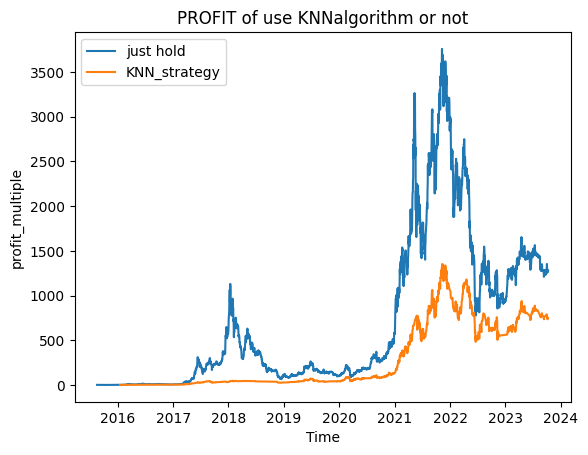

In [320]:
plt.plot(eth_data['date'], eth_data['cumsum'], label='just hold' )
plt.plot(new_eth_data['date'], new_eth_data['cumsum'], label='KNN_strategy')
plt.legend()
plt.xlabel('Time')
plt.ylabel('profit_multiple')
plt.title('PROFIT of use KNNalgorithm or not')
plt.show()